# Model Performance 
This notebook presents a comprehensive analysis of various regression models applied to predict temperature based on environmental sensor data. It includes model comparison, evaluation, prediction on new data.

## Model Performance Comparison

Comparing performance metrics across all trained models:
- Mean Absolute Error (MAE)
- Root Mean Square Error (RMSE)
- R-squared (R²)

Visualizing:
1. RMSE comparison across models
2. R² score comparison
3. Best model's actual vs predicted values
4. Residuals distribution for best model


Model Comparison on New Data:
--------------------------------------------------
      adaboost_model.pkl  gradient_boosting_model.pkl  \
MAE               1.1203                       0.6056   
RMSE              1.5196                       0.9463   
R2                0.6452                       0.8624   

      lasso_regression_model.pkl  linear_regression_model.pkl  \
MAE                       0.4754                       0.1531   
RMSE                      0.5695                       0.1841   
R2                        0.9502                       0.9948   

      polynomial_regression_model.pkl  random_forest_model.pkl  \
MAE                            0.2795                   0.4274   
RMSE                           0.3751                   0.7427   
R2                             0.9784                   0.9152   

      ridge_regression_model.pkl  svr_model.pkl  
MAE                       0.1530         1.5193  
RMSE                      0.1840         1.8223  
R2           

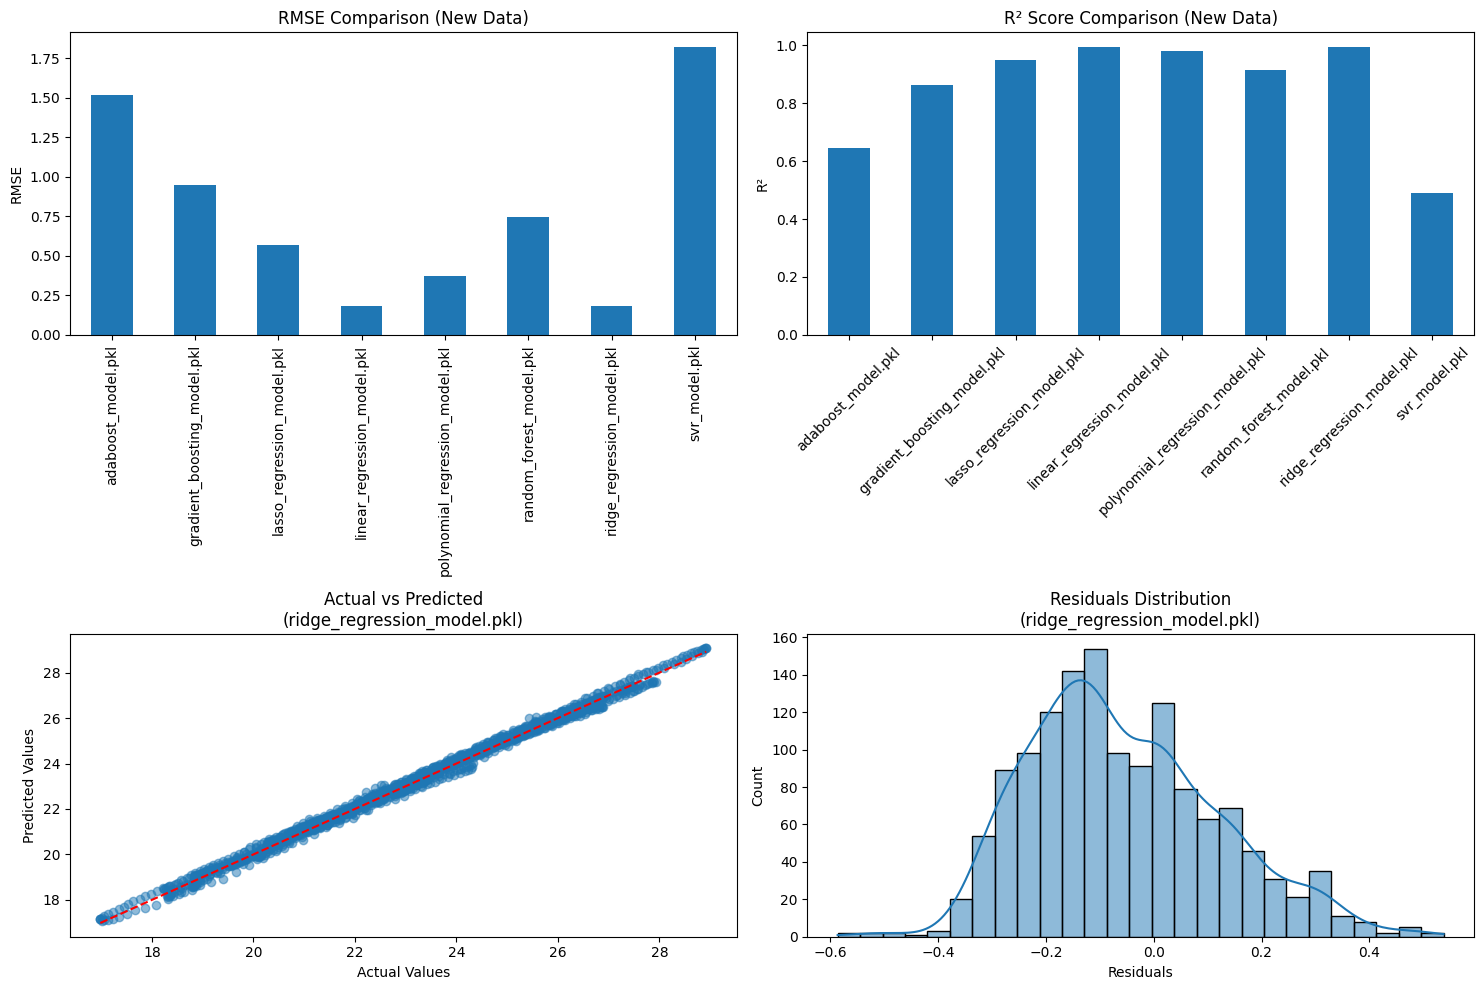

In [6]:
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from data_loader import load_df2

# Load new data for prediction
X_new = load_df2()

feature_columns = [
    'Temperature_Habitacion_Sensor', 'Weather_Temperature',
    'CO2_Comedor_Sensor', 'Humedad_Comedor_Sensor',
    'Lighting_Comedor_Sensor', 'Hour', 'Month', 'Day_Of_Week'
]
target_column = 'Temperature_Comedor_Sensor'

# Get list of all .pkl files in current directory
pkl_files = [f for f in os.listdir() if f.endswith('.pkl')]

# Dictionary to store model performances
model_performances = {}

# For each model file
for model_file in pkl_files:
    try:
        # Load the model
        model = joblib.load(model_file)
        
        # Make predictions on new data
        y_pred = model.predict(X_new[feature_columns])
        y_true = X_new[target_column]
        
        # Calculate metrics
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        
        # Store results and predictions
        model_performances[model_file] = {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'Predictions': y_pred
        }
    except Exception as e:
        print(f"Error loading or evaluating {model_file}: {str(e)}")

# Create comparison DataFrame for metrics
metrics_df = pd.DataFrame({model: {
    'MAE': perf['MAE'],
    'RMSE': perf['RMSE'],
    'R2': perf['R2']
} for model, perf in model_performances.items()}).round(4)

# Display results
print("\nModel Comparison on New Data:")
print("-" * 50)
print(metrics_df)

# Find best model based on RMSE
best_model_file = metrics_df.loc['RMSE'].idxmin()
print(f"\nBest model (based on RMSE): {best_model_file}")

# Create visualization plots
plt.figure(figsize=(15, 10))

# 1. Bar plot for RMSE
plt.subplot(2, 2, 1)
metrics_df.loc['RMSE'].plot(kind='bar')
plt.title('RMSE Comparison (New Data)')
plt.xticks(rotation=90)
plt.ylabel('RMSE')

# 2. Bar plot for R2
plt.subplot(2, 2, 2)
metrics_df.loc['R2'].plot(kind='bar')
plt.title('R² Score Comparison (New Data)')
plt.xticks(rotation=45)
plt.ylabel('R²')

# 3. Actual vs Predicted for best model
plt.subplot(2, 2, 3)
best_predictions = model_performances[best_model_file]['Predictions']
plt.scatter(X_new[target_column], best_predictions, alpha=0.5)
plt.plot([X_new[target_column].min(), X_new[target_column].max()], 
         [X_new[target_column].min(), X_new[target_column].max()], 'r--')
plt.title(f'Actual vs Predicted\n({best_model_file})')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# 4. Residuals plot for best model
plt.subplot(2, 2, 4)
residuals = X_new[target_column] - best_predictions
sns.histplot(residuals, kde=True)
plt.title(f'Residuals Distribution\n({best_model_file})')
plt.xlabel('Residuals')

plt.tight_layout()
plt.show()

Predictions: [20.19991471 20.1614592  20.06034832 ... 18.58373006 18.56575693
 18.60489529]


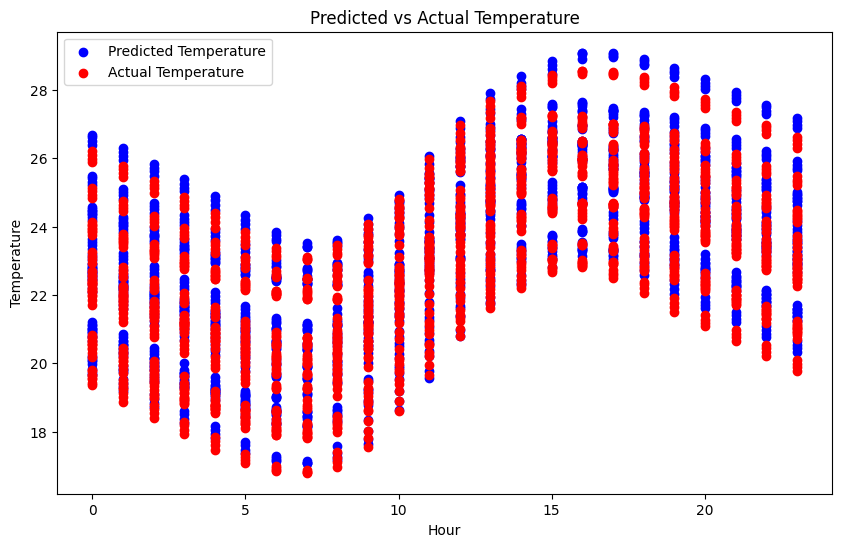

In [7]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
from data_loader import load_df2


# Load the saved model
model = joblib.load(best_model_file)

feature_columns = ['Temperature_Habitacion_Sensor',
                 'Weather_Temperature',
                 'CO2_Comedor_Sensor',
                 'Humedad_Comedor_Sensor',
                 'Lighting_Comedor_Sensor',
                 'Hour',
                 'Month',
                 'Day_Of_Week']
X_input = X_new[feature_columns]

predictions = model.predict(X_input)

print("Predictions:", predictions)
plt.figure(figsize=(10, 6))
plt.scatter(X_new['Hour'], predictions, color='blue', label='Predicted Temperature')
plt.scatter(X_new['Hour'], X_new['Temperature_Habitacion_Sensor'], color='red', label='Actual Temperature')
plt.xlabel('Hour')
plt.ylabel('Temperature')
plt.title('Predicted vs Actual Temperature')
plt.legend()
plt.show()

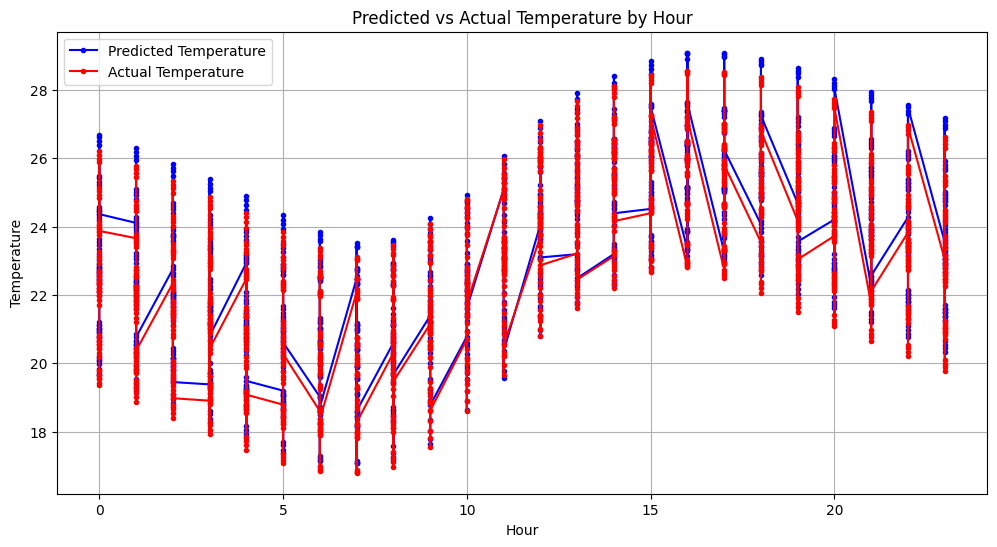

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Add predictions to DataFrame
X_new['Predicted_Temp'] = predictions

# Sort by Hour for smooth plotting
X_sorted = X_new.sort_values(by='Hour')

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(X_sorted['Hour'], X_sorted['Predicted_Temp'], 'b.-', label='Predicted Temperature')
plt.plot(X_sorted['Hour'], X_sorted['Temperature_Habitacion_Sensor'], 'r.-', label='Actual Temperature')
plt.xlabel('Hour')
plt.ylabel('Temperature')
plt.title('Predicted vs Actual Temperature by Hour')
plt.legend()
plt.grid(True)
plt.show()


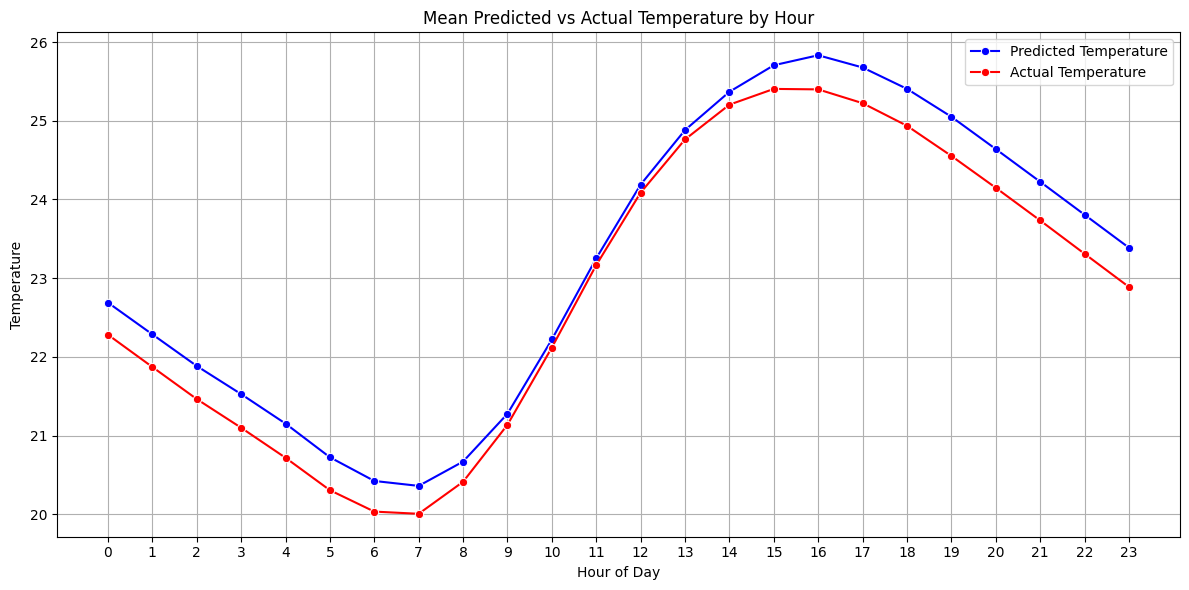

In [9]:
import seaborn as sns

# Group by Hour and calculate mean values
grouped = X_new.groupby('Hour')[['Temperature_Habitacion_Sensor', 'Predicted_Temp']].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='Hour', y='Predicted_Temp', label='Predicted Temperature', marker='o', color='blue')
sns.lineplot(data=grouped, x='Hour', y='Temperature_Habitacion_Sensor', label='Actual Temperature', marker='o', color='red')
plt.title('Mean Predicted vs Actual Temperature by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Temperature')
plt.xticks(range(0, 24))  # if using 24-hour time
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


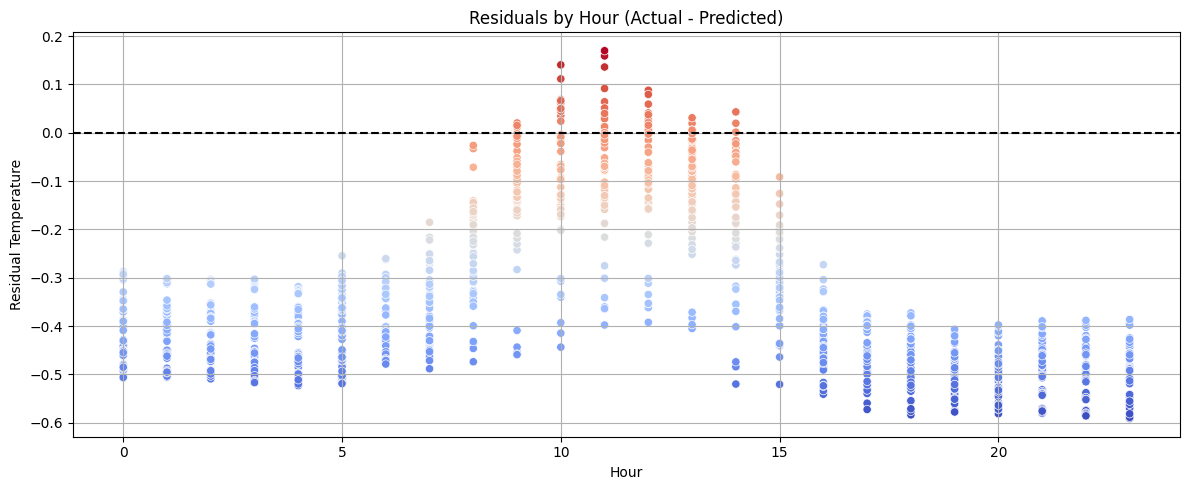

In [10]:
X_new['Residuals'] = X_new['Temperature_Habitacion_Sensor'] - X_new['Predicted_Temp']

plt.figure(figsize=(12, 5))
sns.scatterplot(data=X_new, x='Hour', y='Residuals', hue='Residuals', palette='coolwarm', legend=False)
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals by Hour (Actual - Predicted)')
plt.xlabel('Hour')
plt.ylabel('Residual Temperature')
plt.grid(True)
plt.tight_layout()
plt.show()
